In [1]:
import gc; gc.enable()
import random
import time
from datetime import date, timedelta

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(style = 'white', color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as st
import statsmodels.formula.api as smf

In [2]:
from sklearn import preprocessing, metrics
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
import lightgbm as lgb

In [4]:
dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':str}
# As the unit_sale has negative values (-1) for return items, we transform the unit_sale by log(1+x) when loading the training data.
tra = pd.read_csv('~/Desktop/Kaggle/competitions/favorita-grocery-sales-forecasting/train.csv', dtype=dtypes, converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0}, parse_dates=['date'])
tes = pd.read_csv('~/Desktop/Kaggle/competitions/favorita-grocery-sales-forecasting/test.csv', dtype=dtypes, parse_dates=['date'])
hol = pd.read_csv('~/Desktop/Kaggle/competitions/favorita-grocery-sales-forecasting/holidays_events.csv',dtype={'transferred':str},parse_dates=['date'])
ite = pd.read_csv('~/Desktop/Kaggle/competitions/favorita-grocery-sales-forecasting/items.csv')
oil = pd.read_csv('~/Desktop/Kaggle/competitions/favorita-grocery-sales-forecasting/oil.csv', parse_dates=['date'])
trn = pd.read_csv('~/Desktop/Kaggle/competitions/favorita-grocery-sales-forecasting/transactions.csv', parse_dates=['date'])
sto = pd.read_csv('~/Desktop/Kaggle/competitions/favorita-grocery-sales-forecasting/stores.csv')

### EDA

#### 1. Count Plot for some category variables

In [28]:
# col should be a string, eg: 'city'
def count_plot(df, col):
    f,ax = plt.subplots(1,1,figsize=(18,8))
    ax.set_ylabel('Count')
    c = sns.countplot(x = col, data=df, ax=ax)
    c.set_xticklabels(c.get_xticklabels(),rotation=45)
    plt.show()

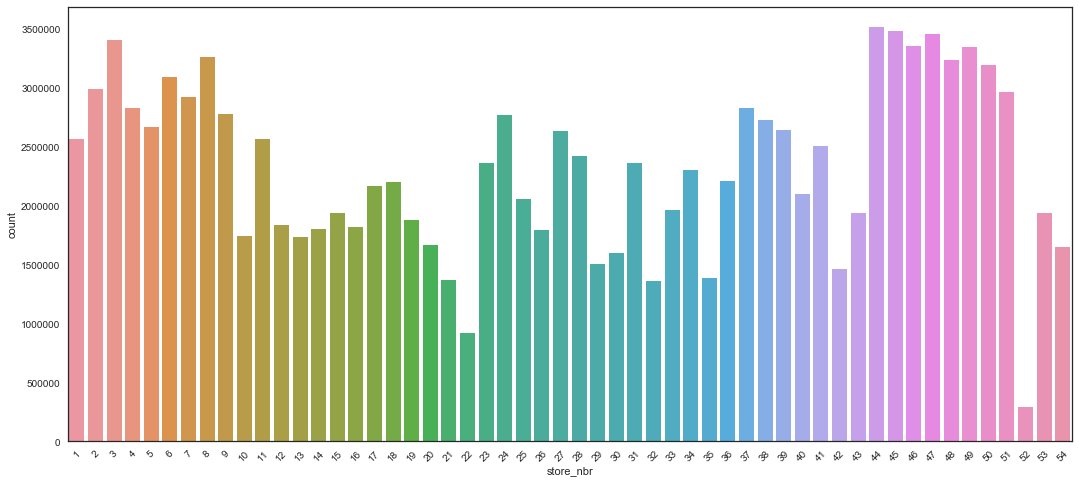

In [63]:
count_plot(tra,'store_nbr')

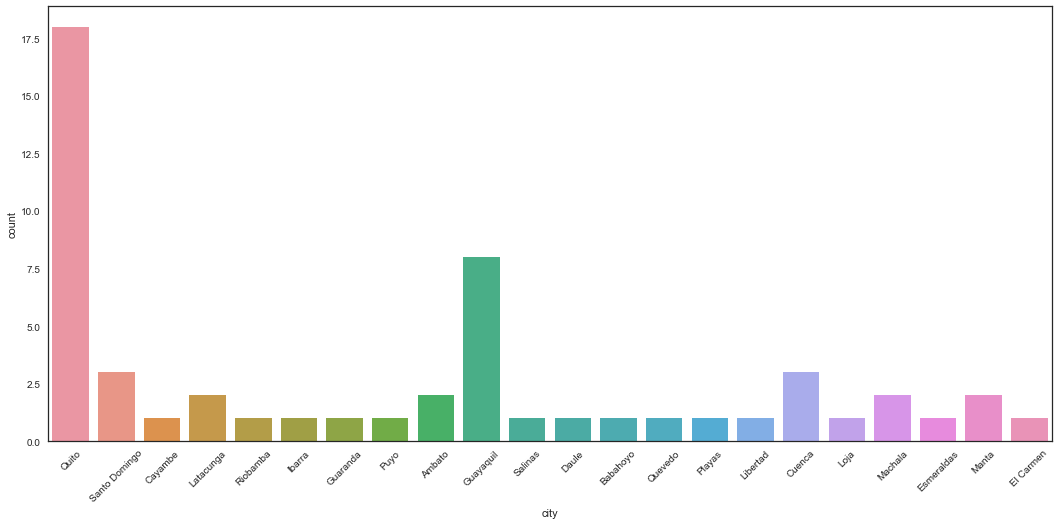

In [29]:
count_plot(sto,'city')

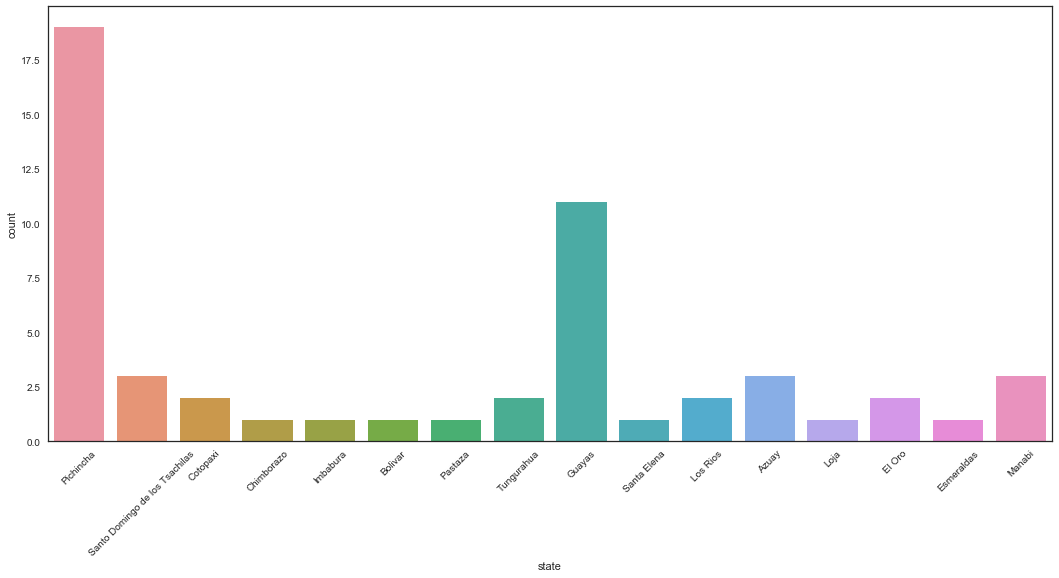

In [30]:
count_plot(sto,'state')

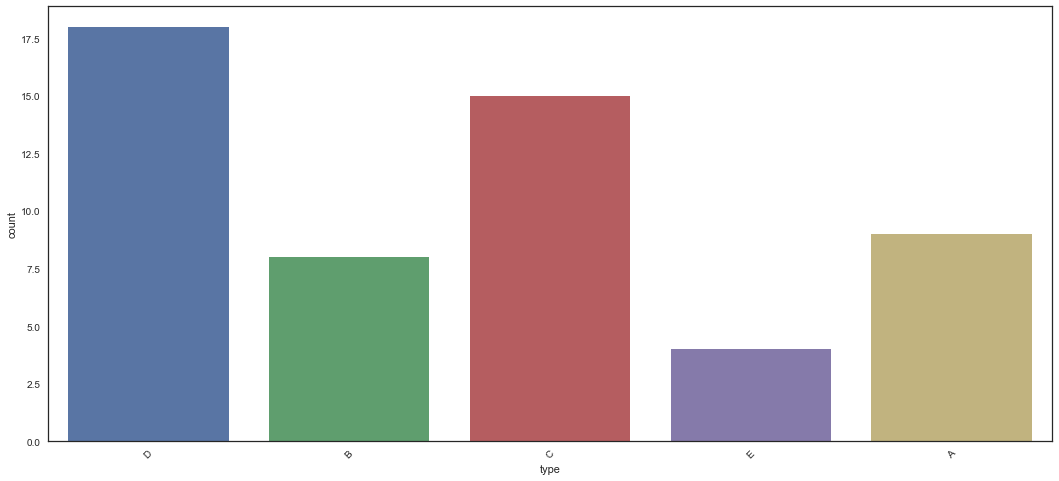

In [31]:
count_plot(sto,'type')

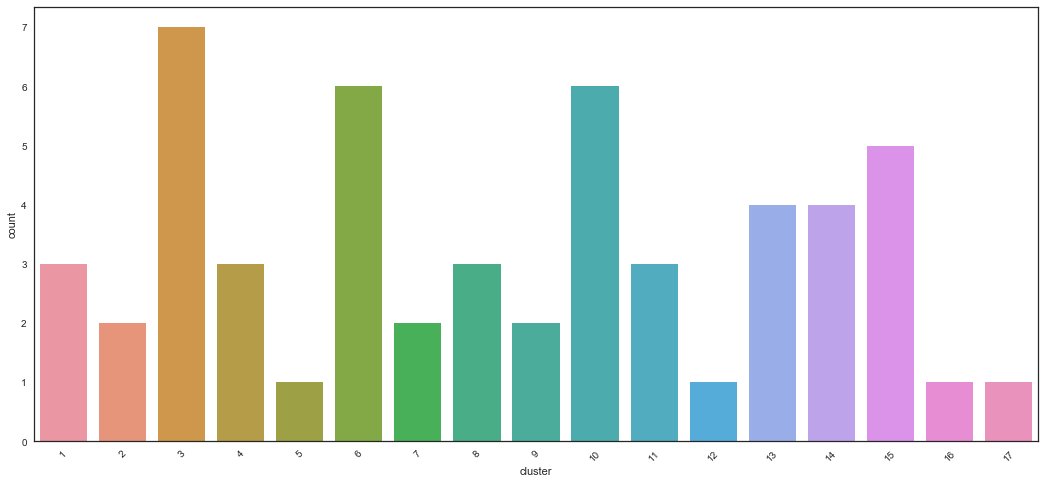

In [32]:
count_plot(sto,'cluster')

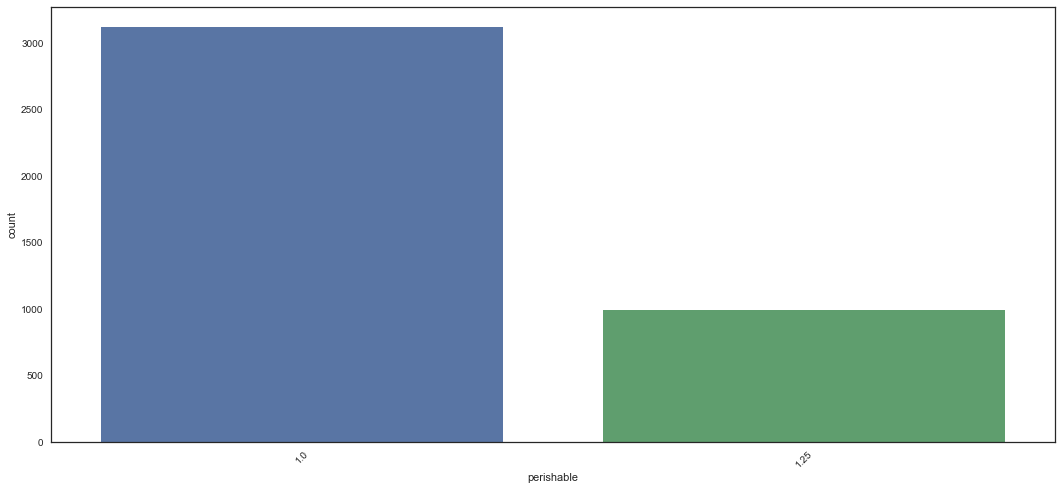

In [68]:
count_plot(ite,'perishable')

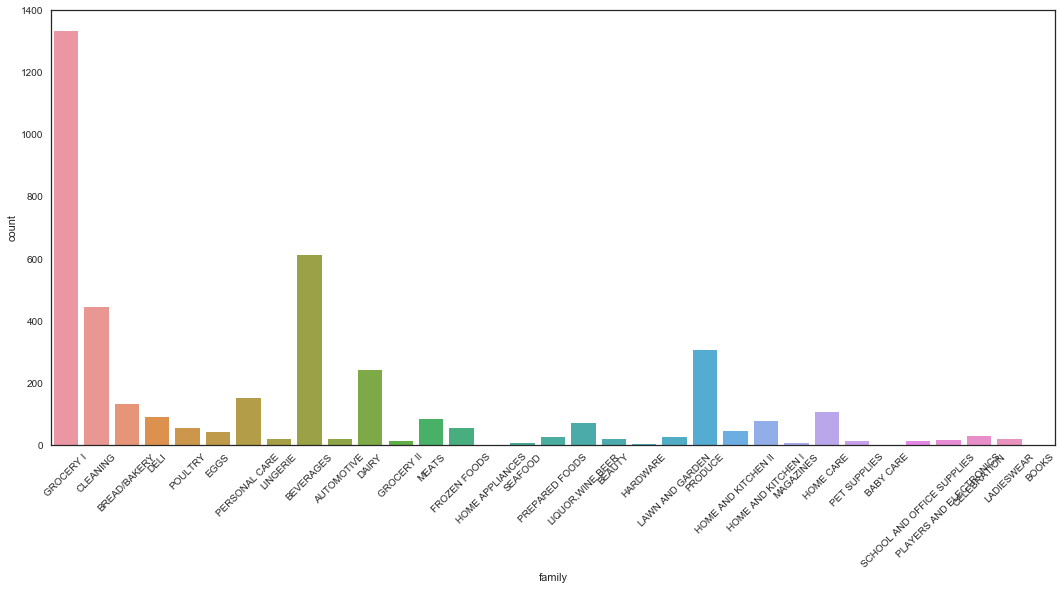

In [33]:
count_plot(ite,'family')

#### 2.  Total sales vs Oil price 

In [70]:
tra['date'] = pd.to_datetime(tra['date'])

In [71]:
total_sales = tra.groupby('date')['unit_sales'].sum().reset_index()

In [72]:
oil['date'] =pd.to_datetime(oil['date'])

In [77]:
oil_unit_sale = pd.merge(total_sales, oil, on=['date'], how='left').set_index('date')

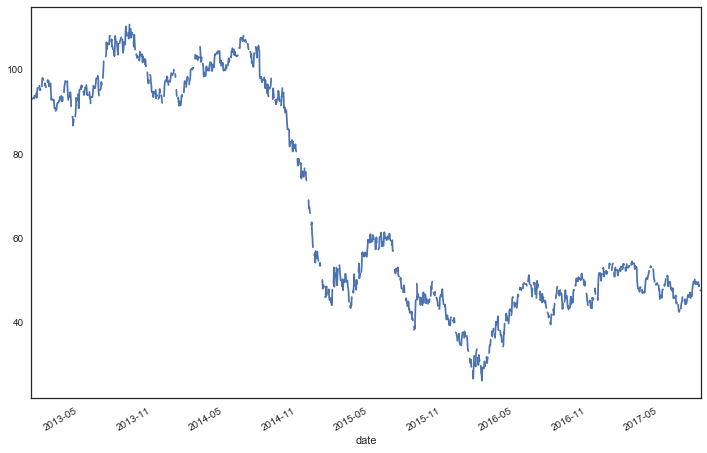

In [78]:
f,ax=plt.subplots(1,1,figsize=(12,8))
oil_unit_sale['dcoilwtico'].plot()

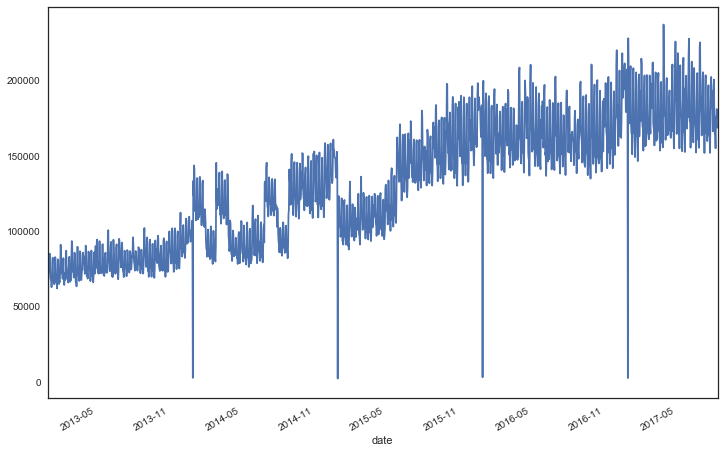

In [75]:
f,ax=plt.subplots(1,1,figsize=(12,8))
oil_unit_sale['unit_sales'].plot()

### Inferiencial statistics

#### 1.total unit sales vs oil price

In [79]:
lm = smf.ols(formula = 'unit_sales ~ dcoilwtico', data = oil_unit_sale).fit()

In [80]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             unit_sales   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     2266.
Date:                Sun, 22 Apr 2018   Prob (F-statistic):          3.85e-275
Time:                        21:14:58   Log-Likelihood:                -13245.
No. Observations:                1163   AIC:                         2.649e+04
Df Residuals:                    1161   BIC:                         2.650e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.029e+05   1774.275    114.356      0.0

#### 2. promotion vs unit sales

In [86]:
promo_sales = tra[tra['onpromotion'] == 'True']['unit_sales']
nopromo_sales = tra[tra['onpromotion'] == 'False']['unit_sales']
st.ttest_ind(promo_sales, nopromo_sales, equal_var = False)

Ttest_indResult(statistic=871.09650011298515, pvalue=0.0)

#### 3. store type vs cluster

In [83]:
ct = pd.crosstab(sto['type'], sto['cluster'])
s, p, _, _, = st.chi2_contingency(ct)
print ('p-value is', p)

p-value is 2.10503318385e-14


Small p-value, reject the Null hyphothes (Store Type and Cluster are independent from each other)

#### 4. store city vs cluster

In [84]:
ct2 = pd.crosstab(sto['city'], sto['cluster'])
s, p, _, _, = st.chi2_contingency(ct2)
print ('p-value is', p)

p-value is 0.733113341849


Large p-value, can not reject the Null hyphothes (Store Type and Cluster are independent from each other)

### Feature Transformation 

#### 1.Filling the missing values

In [19]:
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

In [7]:
tra ['onpromotion'] = tra ['onpromotion'].fillna(False)

#### 2.Select National Holiday

In [56]:
national_hol = hol[(hol['locale'] == 'National') & (hol['transferred'] == 'False')]
national_hol = national_hol[['locale_name','date']]

In [58]:
normal_hol = hol[(hol['locale'] != 'National') & (hol['transferred'] == 'False')]
normal_hol = normal_hol[['locale_name','date']]

In [24]:
test_national_hol = pd.merge(tes, national_hol, on=['date'], how='inner')

We find no national holiday happens in the prediction range.

In [25]:
test_normal_hol = pd.merge(tes, normal_hol, on=['date'], how='inner')

#### 3. category label encoding

In [8]:
def df_lbl_enc(df):
    for c in df.columns:
        if df[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            df[c] = lbl.fit_transform(df[c])
            print(c)
    return df

In [11]:
df_lbl_enc(sto)

city
state
type


,store_nbr,city,state,type,cluster
0,1,18,12,3,13
1,2,18,12,3,13
2,3,18,12,3,8
3,4,18,12,3,9
4,5,21,14,3,4
5,6,18,12,3,13
6,7,18,12,3,8
7,8,18,12,3,8
8,9,18,12,1,6
9,10,18,12,2,15


In [12]:
df_lbl_enc(ite)

family


,item_nbr,family,class,perishable
0,96995,12,1093,0
1,99197,12,1067,0
2,103501,7,3008,0
3,103520,12,1028,0
4,103665,5,2712,1
5,105574,12,1045,0
6,105575,12,1045,0
7,105576,12,1045,0
8,105577,12,1045,0
9,105693,12,1034,0


In [59]:
df_lbl_enc(normal_hol)

locale_name


,locale_name,date
0,14,2012-03-02
1,2,2012-04-01
2,3,2012-04-12
3,11,2012-04-14
4,18,2012-04-21
5,15,2012-05-12
6,6,2012-06-23
7,9,2012-06-25
8,10,2012-06-25
9,13,2012-06-25


#### 4.Mapping perishable and promotion features

In [13]:
ite['perishable'] = ite['perishable'].map({0:1.0, 1:1.25})

In [14]:
tra['onpromotion'] = tra['onpromotion'].map({'False': 0, 'True': 1})

In [15]:
tes['onpromotion'] = tes['onpromotion'].map({'False': 0, 'True': 1})

### Create Time series feature

In [16]:
# Select train data since 2017
tra_2017 = tra.loc[tra['date'] >= pd.datetime(2017,1,1)]
del tra; gc.collect();

#### 1.Data Frame reshape

In [17]:
#Create sale time series on training data 
tra_2017_sale = tra_2017.set_index(['store_nbr','item_nbr','date'])['unit_sales'].unstack(level=-1).fillna(0)

In [134]:
tra_2017_sale.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0    0.000000    0.000000    0.000000   
          99197            0.0    0.000000    1.386294    0.693147   
          103520           0.0    0.693147    1.098612    0.000000   
          103665           0.0    0.000000    0.000000    1.386294   
          105574           0.0    0.000000    1.791759    2.564949   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.693147    0.693147    1.098612    0.000000   
          103520      1.098612    1.386294    0.693147    0.000000   
          103665      1.098612    1.098612    0.693147    1.098612   
          105574      2.302585    1.945910    1.609438    1.098612   

date                2017-01-09  2017-01-10     ...      2017-08-06  \
store_nbr item_nbr                             ...                   
1         96995       0.000000    0.000000     ...        1.098612   
          99197       0.000000    0.693147     ...        0.000000   
          103520      0.693147    0.693147     ...        0.000000   
          103665      0.000000    2.079442     ...        0.693147   
          105574      1.386294    2.302585     ...        0.000000   

date                2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr item_nbr                                                   
1         96995       1.098612    0.000000    0.000000    0.693147   
          99197       1.098612    0.000000    1.098612    0.000000   
          103520      0.000000    1.386294    0.000000    1.386294   
          103665      1.098612    0.000000    2.079442    2.302585   
          105574      1.791759    2.079442    1.945910    2.397895   

date                2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                              
1         96995       0.000000    0.000000    0.000000    0.000000    0.000000  
          99197       0.000000    0.000000    0.000000    0.000000    0.000000  
          103520      0.693147    0.693147    0.693147    0.000000    0.000000  
          103665      1.098612    0.000000    0.000000    0.693147    0.693147  
          105574      1.791759    1.791759    0.000000    1.386294    1.609438  

[5 rows x 227 columns]

In [292]:
#Create aggreagte sale and promotion time series on training data 
#tra_2017_sale_item = tra_2017_sale.groupby('item_nbr').sum()
#pro_2017_item = pro_2017.groupby('item_nbr').sum()

In [18]:
#set the index of item meta data the same as the reshaped training dataset 
ite = ite.set_index('item_nbr')
ite = ite.reindex(tra_2017_sale.index.get_level_values(1))

In [19]:
# set the index of store meta data the same as the reshaped training dataset 
sto = sto.set_index('store_nbr')
sto = sto.reindex(tra_2017_sale.index.get_level_values(0))

In [20]:
# Create promotion time series on training data
tra_2017_pro = tra_2017.set_index(['store_nbr','item_nbr','date'])['onpromotion'].unstack(level=-1).fillna(0)

# Create promotion time series on test data
tes_pro = tes.set_index(['store_nbr','item_nbr','date'])['onpromotion'].unstack(level=-1).fillna(0)
tes_pro = tes_pro.reindex(tra_2017_pro.index).fillna(0)

# Join promotion time series training and test data
pro_2017 = pd.concat([tra_2017_pro, tes_pro], axis=1)

#### 2.Define time window functions 

In [21]:
#moving statistics for days of intevals
def moving_stats(df, time, delta,freq ='D'):
    X = pd.DataFrame()   
    #Slicling dataframe from the 'time' + 'delta' days
    #df_after = df[pd.date_range(start=time, periods = delta, freq = freq)]
    #Slicling dataframe from the 'time' - 'delta' days
    df_before = df[pd.date_range(end=time-timedelta(1), periods = delta, freq = freq)]    
    # Get statistical features within 'delta' intervals
    X ['mean(%s)_b%s'% (delta,time)] = df_before.mean(axis=1).values
    X ['median(%s)_b%s'% (delta,time)] = df_before.median(axis=1).values
    X ['min(%s)_b%s'% (delta,time)] = df_before.min(axis=1).values
    X ['max(%s)_b%s'% (delta,time)] = df_before.max(axis=1).values
    X ['std(%s)_b%s'% (delta,time)] = df_before.std(axis=1).values    
    X ['mean(%s)diff_b%s' % (delta,time)] = df_before.diff(axis=1).mean(axis=1).values
    X ['mean(%s)decay_b%s' % (delta,time)] = (df_before * np.power(0.9, np.arange(delta)[::-1])).mean(axis=1).values
    
    return X

In [22]:
#moving aggregation for days of intevals
def moving_agg(df, time, delta,freq ='D'):
    X = pd.DataFrame()
    df_before = df[pd.date_range(end=time-timedelta(1), periods = delta, freq = freq)]
    
    X ['sum(%s)_b%s'% (delta,time)] = df_before.sum(axis=1).values
    
    return X

In [23]:
# Slicing consecutive days  
def slicing_consecutive(df, time, delta, freq ='D'):
    X = {}
   
    X = df[pd.date_range(end=time-timedelta(1), periods = delta, freq = freq)].values
    column_name = df[pd.date_range(end=time-timedelta(1), periods = delta, freq = freq)].columns
    
    X = pd.DataFrame(X, columns =column_name)
    
    return X

#### 3.Create time series features based on the defined time window functions. 

In [24]:
def preparing_data_X(t2017, df_sale, df_pro, name_prefix=None):
# Calculate the sales moving statistics and moving aggregation for different days of intevals
    X_sale = pd.DataFrame()
    days_of_interval = [3, 7, 14, 30, 60, 140]  
    pred_len = len(tes['date'].unique())  # the length of prediction days 

    for interval in days_of_interval :
        X1 = moving_stats(df_sale, t2017, interval)
        X2 = moving_stats(df_sale, t2017-timedelta(7), interval)
        X3 = moving_agg(df_sale, t2017, interval)
        X_sale = pd.concat([X_sale,X1,X2,X3],axis =1)

# Slicing consecutive days in sales
    X4 = slicing_consecutive(df_sale,t2017,pred_len)
    X_sale = pd.concat([X_sale,X4],axis =1)
    
# Calculate the promotiona moving aggregation for different days of intevals    
    X_pro = pd.DataFrame()
    days_of_interval_1 = [14, 60, 140]
    days_of_interval_2 = [3,7,14]

    pred_len = len(tes['date'].unique())
                     
    for interval in days_of_interval_1 :
        X1 = moving_agg(df_pro, t2017, interval)
        X_pro = pd.concat([X_pro,X1],axis =1)
    
    for interval in days_of_interval_2 :   
        X2 = moving_agg(df_pro, t2017 + timedelta(1) + timedelta(interval),interval)
        X_pro = pd.concat([X_pro,X2],axis =1)

# Slicing consecutive days in pro
    X3 = slicing_consecutive(df_pro,t2017,pred_len)
    X4 = slicing_consecutive(df_pro,t2017+timedelta(pred_len),pred_len)
    X_pro = pd.concat([X_pro,X3,X4],axis =1)
    
    X = pd.concat([X_sale,X_pro],axis =1)
    
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
        
    return X.values

In [25]:
def preparing_data_y (t2017, df_sale):
    pred_len = len(tes['date'].unique())
    
    y = slicing_consecutive(df_sale,t2017+timedelta(pred_len),pred_len)
    
    return y.values 

### Machine Learning models

####  1.Prepare data set

In [26]:
#Preparing folders of training data set
X, y = [], []
folders = 4

for i in range(folders):
    delta = timedelta(days=7 * i)
    X_tmp = preparing_data_X(date(2017, 6, 14) + delta, tra_2017_sale, pro_2017)
    y_tmp = preparing_data_y(date(2017, 6, 14) + delta, tra_2017_sale) 
    X.append(X_tmp)
    y.append(y_tmp)
    
X_train = np.concatenate(X, axis=0)
y_train = np.concatenate(y, axis=0)

In [27]:
#Preparing validation data set
X_val = preparing_data_X(date(2017, 7, 26),tra_2017_sale, pro_2017)
y_val = preparing_data_y(date(2017, 7, 26),tra_2017_sale)

In [28]:
#Preparing test data set 
X_test = preparing_data_X(date(2017, 8, 16),tra_2017_sale, pro_2017)

In [29]:
#Prepare scale datasets
scaler = preprocessing.StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.fit_transform(X_val)
X_test_s = scaler.fit_transform(X_test)

#### 2. Define evaluation metrics

In [30]:
#Calculate the Normalized Weighted Root Mean Squared Logarithmic Error 
def nwrmsle (y, pred):
    weight = ite["perishable"].values
    pred = np.array(pred).transpose()
    err =(np.log(y+1) - np.log(pred +1))**2
    err = err.sum(axis=1) * weight
    err = np.sqrt(err.sum() / weight.sum() / 16)
    print('nwrmsle = {}'.format(err))    

#### 3.1 Liner regression models_Ridge and Lasso

In [31]:
#16 Liner regression models_Lasso on scaled data
from sklearn import linear_model

model = linear_model.Lasso(alpha = 0.1)

val_pred = []
test_pred = []

for i in range (16):
    model.fit(X_train_s, y_train[:,i])
    val_pred.append(model.predict(X_val_s))
    test_pred.append(model.predict(X_test_s))

nwrmsle(y_val,val_pred)

nwrmsle = 0.3370012403947538


In [44]:
#16 Liner regression models_Ridge on scaled dataset
from sklearn import linear_model

model = linear_model.Ridge (alpha = 0.5)
val_pred = []
test_pred = []

for i in range (16):
    model.fit(X_train_s, y_train[:,i])
    val_pred.append(model.predict(X_val_s))
    test_pred.append(model.predict(X_test_s))

nwrmsle(y_val,val_pred)

nwrmsle = 0.32294528746799755


#### 3.2 Support Vector Machine 

In [37]:
# 16 Support Vector Machine models on scaled dataset
from sklearn import svm

model = svm.LinearSVR()
val_pred = []
test_pred = []

for i in range (16):
    model.fit(X_train_s, y_train[:,i])
    val_pred.append(model.predict(X_val_s))
    test_pred.append(model.predict(X_test_s))

nwrmsle(y_val,val_pred)

nwrmsle = 0.32922112263898434


#### 3.3 Extra Tree Models 

In [35]:
# 16 ExtraTrees models
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
val_pred = []
test_pred = []

for i in range (16):
    model.fit(X_train, y_train[:,i])
    val_pred.append(model.predict(X_val))
    test_pred.append(model.predict(X_test))

nwrmsle(y_val,val_pred)

nwrmsle = 0.33125629069949236


#### 3.4 Random Forest models 

In [38]:
#16 Random Forest models 
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
val_pred = []
test_pred = []

for i in range (16):
    model.fit(X_train, y_train[:,i])
    val_pred.append(model.predict(X_val))
    test_pred.append(model.predict(X_test))

nwrmsle(y_val,val_pred)

nwrmsle = 0.33167082556360583


#### 3.5 light GBM models 

In [161]:
# 16 light GBM models 
params = {
    'num_leaves': 100,
    'objective': 'regression',
    'max_depth': 6,
    'min_data_in_leaf': 200,
    'learning_rate': 0.05,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.4,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16,
     'max_bin': 127
}

MAX_ROUNDS = 1000
val_pred = []
test_pred = []
cate_vars = []
folders = 4
pred_len = len(tes['date'].unique())

for i in range(pred_len):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([ite["perishable"]] * folders)
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=ite["perishable"],
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=50
    )
    
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", metrics.mean_squared_error(y_val, np.array(val_pred).transpose()))

Step 1


/Users/zuochaozhao/anaconda/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.312864	valid_1's l2: 0.306576
[100]	training's l2: 0.298167	valid_1's l2: 0.29444
[150]	training's l2: 0.294727	valid_1's l2: 0.292684
[200]	training's l2: 0.292516	valid_1's l2: 0.292015
[250]	training's l2: 0.2908	valid_1's l2: 0.291715
[300]	training's l2: 0.289216	valid_1's l2: 0.29147
[350]	training's l2: 0.287828	valid_1's l2: 0.291296
[400]	training's l2: 0.286497	valid_1's l2: 0.291045
[450]	training's l2: 0.285303	valid_1's l2: 0.291076
Early stopping, best iteration is:
[409]	training's l2: 0.286278	valid_1's l2: 0.291038
Step 2
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.330338	valid_1's l2: 0.339684
[100]	training's l2: 0.318201	valid_1's l2: 0.327984
[150]	training's l2: 0.314918	valid_1's l2: 0.325919
[200]	training's l2: 0.312658	valid_1's l2: 0.324909
[250]	training's l2: 0.310821	valid_1's l2: 0.324548
[300]	training's l2: 0.309112	valid_1's l2: 0

Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.364324	valid_1's l2: 0.389913
[100]	training's l2: 0.348482	valid_1's l2: 0.374303
[150]	training's l2: 0.343617	valid_1's l2: 0.371642
[200]	training's l2: 0.340744	valid_1's l2: 0.371032
[250]	training's l2: 0.338309	valid_1's l2: 0.370629
[300]	training's l2: 0.33624	valid_1's l2: 0.370386
[350]	training's l2: 0.334412	valid_1's l2: 0.370231
[400]	training's l2: 0.332855	valid_1's l2: 0.370182
[450]	training's l2: 0.331278	valid_1's l2: 0.370156
[500]	training's l2: 0.329863	valid_1's l2: 0.370032
[550]	training's l2: 0.328557	valid_1's l2: 0.370009
Early stopping, best iteration is:
[516]	training's l2: 0.329398	valid_1's l2: 0.369967
Step 11
Training until validation scores don't improve for 50 rounds.
[50]	training's l2: 0.393276	valid_1's l2: 0.394909
[100]	training's l2: 0.376871	valid_1's l2: 0.382039
[150]	training's l2: 0.371453	valid_1's l2: 0.379818
[200]	training's l2: 0.368213	valid_1's l

In [146]:
nwrmsle(y_val,val_pred)

nwrmsle = 0.3142811400188674


In [67]:
#Transform test set for submission
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(y_test, index=tra_2017_sale.index,
                        columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")

df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

tes = tes.set_index(['store_nbr', 'item_nbr', 'date']).sort_index(level= 1)

submission = tes[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('~Desktop/project2_sub1.csv', float_format='%.4f', index=None)